In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
# DSP data
fpath = "../../data/DNN_data/"

sig = np.load(fpath + "data_signal" + ".npy")
artifact = np.load(fpath + "data_sine_wave" + ".npy")
sig_with_artifact = sig + artifact

sig_with_artifact.shape

(1000, 4000)

Text(0.5, 1.0, 'Signal with Artifact Signal')

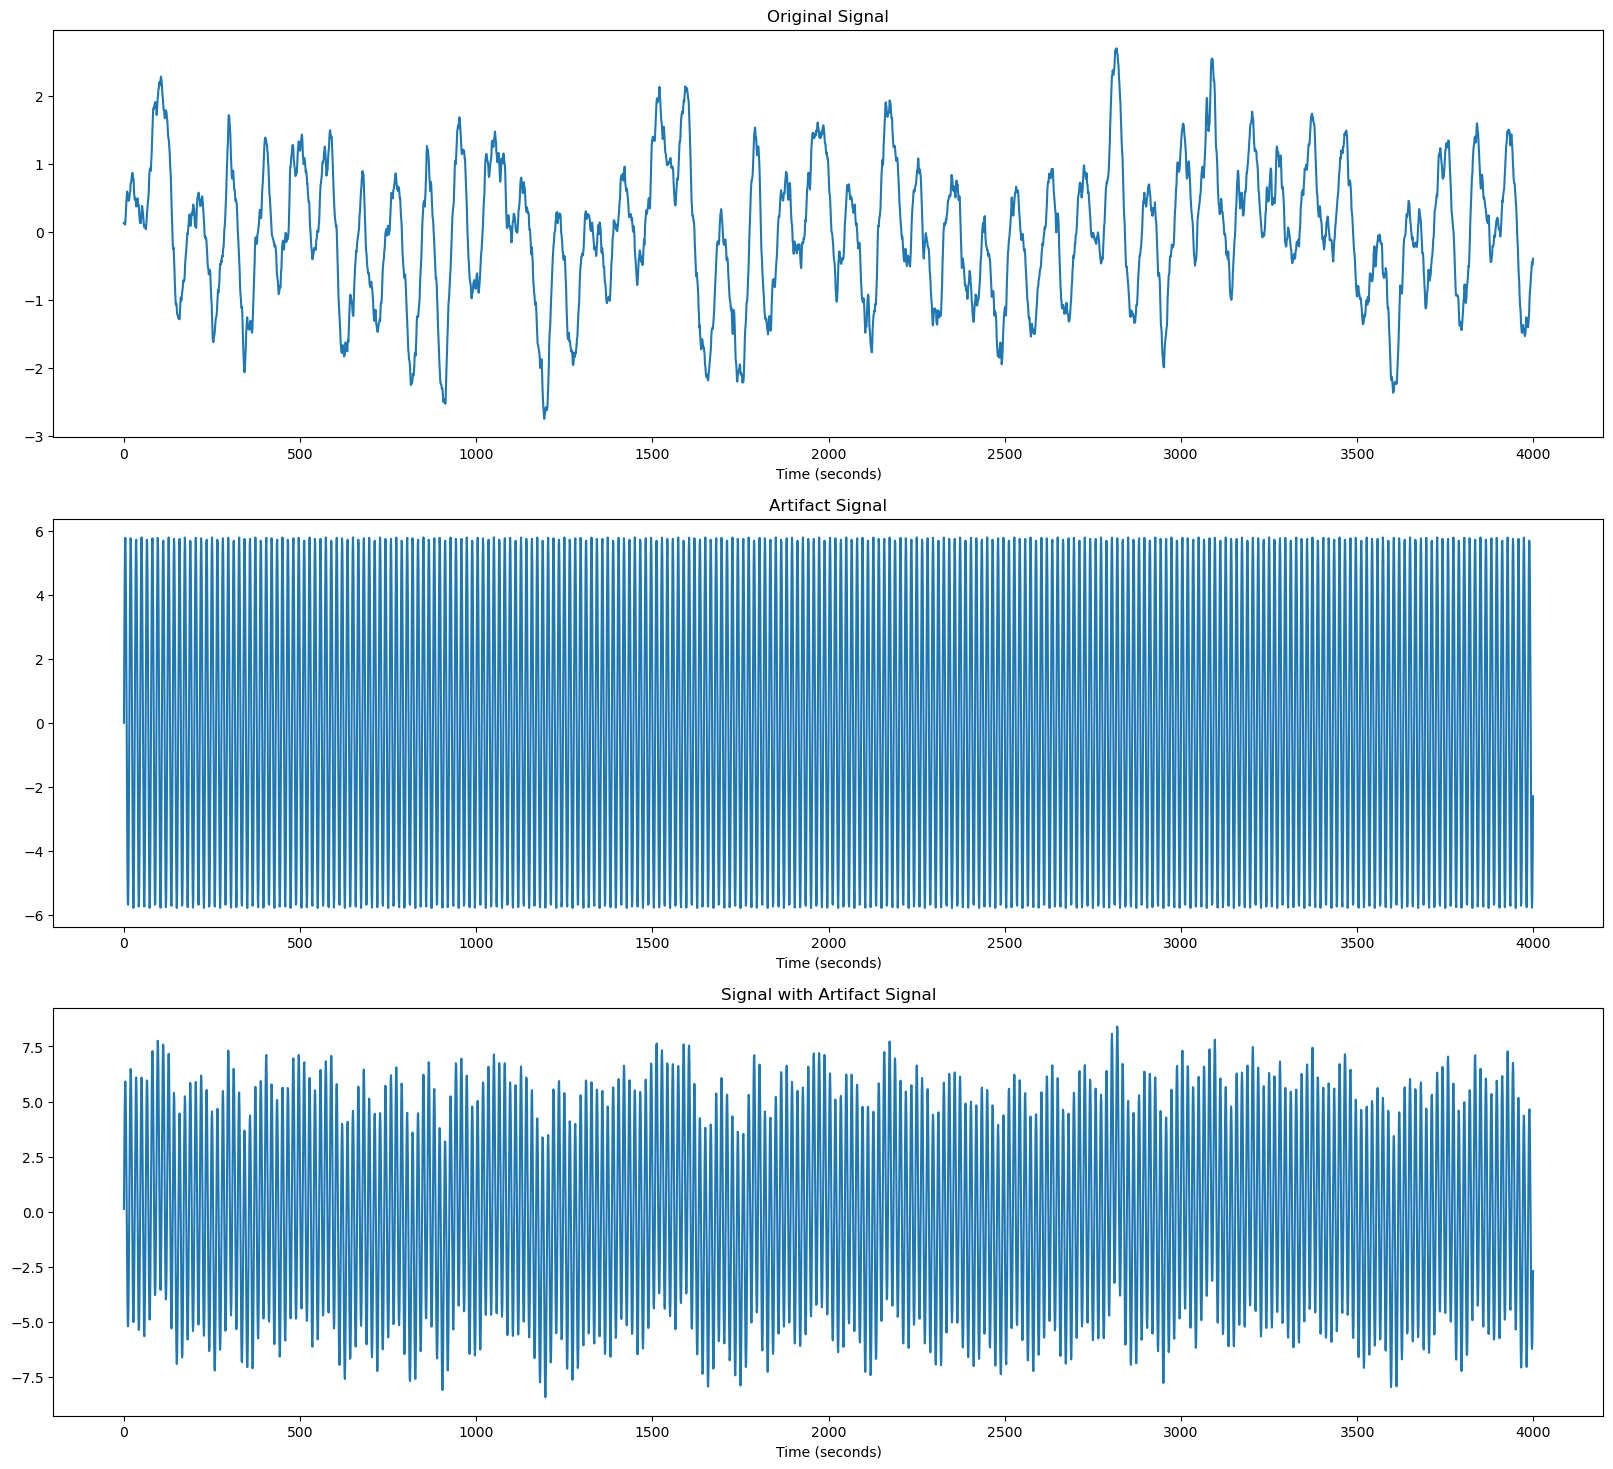

In [17]:
plt.figure(figsize=(20,18))
plt.subplot(3, 1, 1)
plt.plot(sig[0])
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.subplot(3, 1, 2)
plt.plot(artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(sig_with_artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

In [18]:
# 정규화
scaler = MinMaxScaler()
X = scaler.fit_transform(sig_with_artifact)
y = scaler.fit_transform(sig)

print(X.shape)
print(y.shape)

(1000, 4000)
(1000, 4000)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32) # B x T
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = X_train.unsqueeze(1) # B x 1 x T
y_train = y_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)
y_test = y_test.unsqueeze(1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

torch.Size([800, 4000])
torch.Size([800, 4000])
torch.Size([200, 4000])
torch.Size([200, 4000])
torch.Size([800, 1, 4000])
torch.Size([800, 1, 4000])
torch.Size([200, 1, 4000])
torch.Size([200, 1, 4000])


In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3, padding=1)  # Maintain length
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 1, 3, padding=1)  # Output layer to match input dimensions
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        return x

In [21]:
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

for epoch in range(num_epochs):
    for i,(train_, label_) in enumerate(dataloader):        
        optimizer.zero_grad()
        y_pred = model(train_)
        loss = criterion(y_pred,label_)
        loss.backward()
        optimizer.step()
    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/100, Loss: 0.0022341266740113497
Epoch 10/100, Loss: 0.0017827971605584025
Epoch 15/100, Loss: 0.0018987396033480763
Epoch 20/100, Loss: 0.0019755633547902107
Epoch 25/100, Loss: 0.0019400351447984576
Epoch 30/100, Loss: 0.0013503222726285458
Epoch 35/100, Loss: 0.0015768392477184534
Epoch 40/100, Loss: 0.0018291219603270292
Epoch 45/100, Loss: 0.0014392529847100377
Epoch 50/100, Loss: 0.0014981384156271815
Epoch 55/100, Loss: 0.0016684759175404906
Epoch 60/100, Loss: 0.0016699322732165456
Epoch 65/100, Loss: 0.0015463688177987933
Epoch 70/100, Loss: 0.0015833255602046847
Epoch 75/100, Loss: 0.001389175420626998
Epoch 80/100, Loss: 0.001569747575558722
Epoch 85/100, Loss: 0.0013569002039730549
Epoch 90/100, Loss: 0.0015360908582806587
Epoch 95/100, Loss: 0.001518984092399478
Epoch 100/100, Loss: 0.0016656274674460292


In [22]:
# 모델 평가
model.eval()
with torch.no_grad():
    val_outputs = model(X_test)
    val_loss = criterion(val_outputs, y_test)
    print(f'Validation Loss: {val_loss.item():.4f}')

Validation Loss: 0.0016


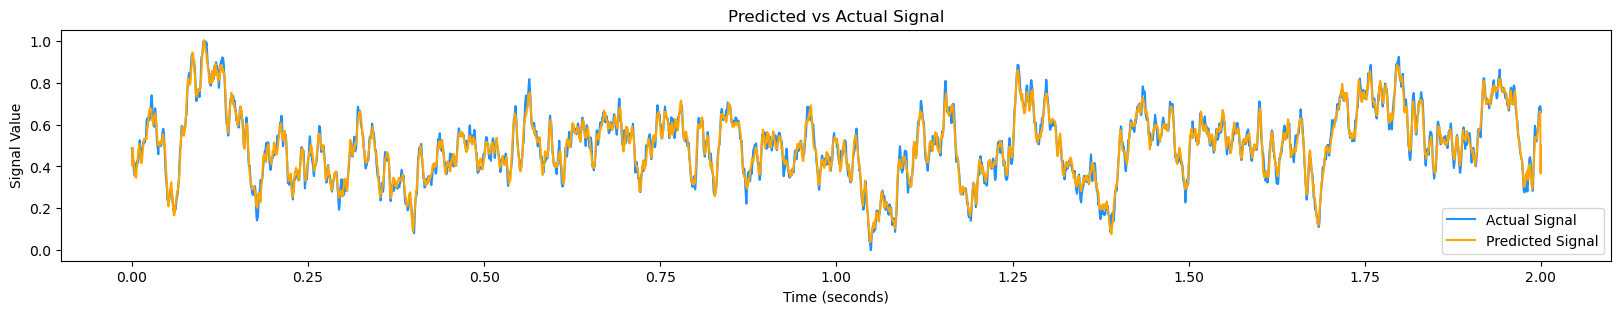

Mean Absolute Error: 0.024227188900113106
Mean Squared Error: 0.0009358389652334154


In [23]:
val_outputs1 = val_outputs.view(200, 4000).numpy()
y_val1 = y_test.view(200, 4000).numpy()

predicted_signal = val_outputs1[0]
actual_signal = y_val1[0]

# 타임 스텝을 시간 단위로 변환
time_steps = np.linspace(0, 2, num=4000)  

plt.figure(figsize=(20, 3))
plt.plot(time_steps, actual_signal, label='Actual Signal', color='dodgerblue')
plt.plot(time_steps, predicted_signal, label='Predicted Signal', color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

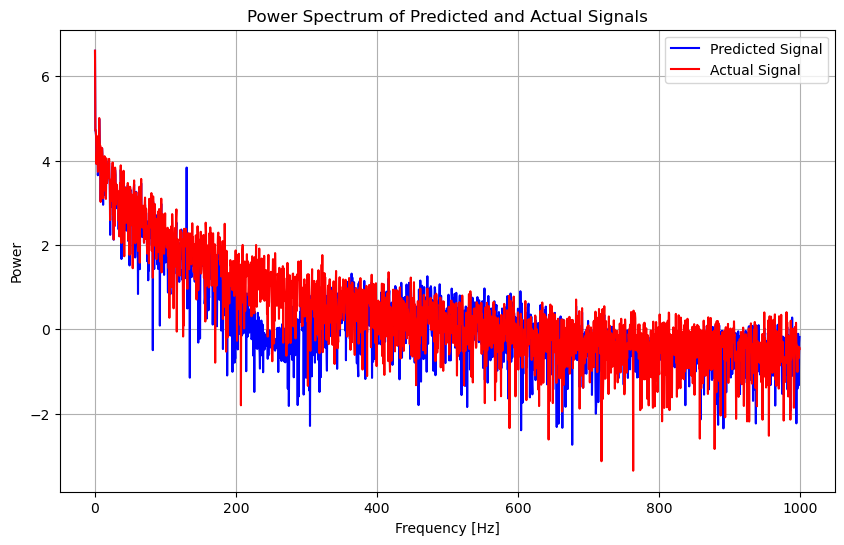

Mean Absolute Error: 0.5406275245014467
Mean Squared Error: 0.5482346108180418


In [26]:
n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='blue')
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='red')
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")